In [1]:
%matplotlib inline
import time
from pprint import pprint

import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import seaborn as sn
import utils
from matplotlib import colors
from sklearn import model_selection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

sn.set(style="ticks")
plt.style.use("ggplot")

# Comparing models and choosing hyperparameters

This notebook provides a basic framework for:

 1. Tuning the hyperparameters of individual classification algorithms, and 
 2. Comparing the performance of various different algorithms (with different hyperparameters)
 
Scikit-Learn provides a wide range of algorithms for **supervised classification** (see [here](https://scikit-learn.org/stable/supervised_learning.html) for an overview). It should be possible to use any of Sklearn's **classification** (not regression) algorithms in this notebook. I've imported seven suggested algorithms in the code above, but feel free to add others if you wish.

**Tip:** If you're trying out a new algorithm, start off with a **small training dataset** (maybe 10,000-ish rows) and, if it works, scale things up. If you go straight for millions of rows, you'll likely get lots of crashes (plus 5 to 10 minute delays as the cluster recovers before you can restart).

**Note:** To run this notebook in its present form, you will need to **sign in to the JupyterHub on one of the larger machines**: either "High memory" (48 GB RAM; 8 CPUs) or "High memory & high CPU" (60 GB RAM; 16 CPUs). For long-running computations, please remember to **check progress periodically and shut down your server when you're finished**. (This doesn't mean you need to be tied to your computer; you can shut down your server pretty easily from your phone).

## 1. Set user options

In [2]:
# Specify area(s) from which to build train/test dataset
area_list = [1, 3, 6]

# Specify area for 'final' test image (should NOT be in the list above)
pred_area = 2

# Number of samples to use for training and testing
train_size = 1e4
test_size = 1e4

# For repeatability of random numbers
seed = 42

# Scoring metric for model comparison
metric = "accuracy"

# Number of folds for CV
n_folds = 10

# Whether to equalise images using linear histogram stretch
equalise = False

assert (
    pred_area not in area_list
), "'pred_area' should be an independent test i.e. not included in 'area_list'."

In [3]:
# Define colourbar
# Class codes for "truth" datasets
class_codes = {
    -1: "Other",
    0: "No data",
    1: "Brown algae",
    2: "Green algae",
    3: "Red algae",
    4: "Eelgrass",
    5: "Rock",
    6: "Sand",
    7: "Lichen",
    8: "Lichen (2)",
    9: "Terrestrial vegetation",
    10: "Beach/shingle",
}

# Define colours for classes. Ordered -1 to 10 (i.e. same as in 'class_codes', above)
cmap = colors.ListedColormap(
    [
        "lightcyan",
        "black",
        "tan",
        "lawngreen",
        "red",
        "none",
        "lightgrey",
        "gold",
        "magenta",
        "none",
        "mediumseagreen",
        "orange",
    ]
)
bounds = np.arange(-1.5, 11.5)
norm = colors.BoundaryNorm(bounds, cmap.N)

## 2. Build dataset for training and evaluation

We begin by reading all the data from several different areas, so that our training dataset has a mixture of pixels from different parts of the study region. The three areas chosen above together have ~19 million pixels, which is too large and slow for the kind of experimentation we want to do here. I've therefore set both `train_size` and `test_size` to 2 million rows. This should be more manageable, while still providing a realistic impression of performance.

We also read in a fourth image, which is kept separately and used for final testing and visualisation.

You are welcome to **use data from other areas** and **choose different scoring metrics** (see Sklearn's documentation). Also **consider setting `equalise=True`** in the options above. This should have no effect on "non-parametric" methods (like random forest) but could affect some of the other classifiers.

In [4]:
# Read train/test image data
df_list = []
for area in area_list:
    df = utils.image_to_sample_df(area, equalise=equalise)
    df_list.append(df)

df = pd.concat(df_list, axis="rows")
del df_list

# Split into training and evaluation
cols = [str(i) for i in range(1, 9)]
X_train, X_eval, y_train, y_eval = train_test_split(
    df[cols],
    df["y"],
    train_size=int(train_size),
    test_size=int(test_size),
    random_state=seed,
    shuffle=True,
)

assert len(X_train) == len(y_train)
assert len(X_eval) == len(y_eval)

print(f"Total number of samples in dataset:      {(len(df) / 1E6):.2f} million.")
print(f"Number of samples in training dataset:   {(len(X_train) / 1E6):.2f} million.")
print(f"Number of samples in evaluation dataset: {(len(X_eval) / 1E6):.2f} million.")

Total number of samples in dataset:      18.87 million.
Number of samples in training dataset:   0.01 million.
Number of samples in evaluation dataset: 0.01 million.


In [5]:
# Read bands for 'final' test image
pred_df = utils.image_to_sample_df(pred_area, equalise=equalise, dropna=False)
del pred_df["y"]

# Read manually classified "truth" datset
man_path = f"/home/jovyan/shared/drones/frisk_oslofjord/raster/ne_akeroya_5cm_area_{pred_area}_man_class.tif"
man_img, ndv, man_epsg, extent = nivapy.spatial.read_raster(man_path, band_no=1)

print(f"Total number of pixels in test image: {(len(pred_df) / 1E6):.2f} million.")

Total number of pixels in test image: 13.32 million.


## 3. Explore hyperparameters for an individual model

At the top of this notebook I've imported seven classifiers as a starting point (feel free to change them if you like):

 * LogisticRegression
 * LinearDiscriminantAnalysis
 * RidgeClassifier
 * GaussianNB
 * KNeighborsClassifier
 * DecisionTreeClassifier
 * RandomForestClassifier

The first of these is essentially the same as the method you implemented with Guri (which I think was multinomial logistic regression?). This is a linear approach, as is `LinearDiscriminantAnalysis` and the `RidgeClassifier`. `GaussianNB` is a very simple method, but it can be effective in some circumstances. The `KNeighborsClassifier` is also conceptually simple, but often surprisingly powerful. The last two are tree-based classifiers, where the `RandomForestClassifier` is just an ensemble of `DecisionTreeClassifiers`. These two - together with KNN - are non-parametric methods, which makes them both flexible and powerful.

As a starting point, I recommend reading the online documentation for each of these models. Most of the algorithms will have a general introduction (linked from [here](https://scikit-learn.org/stable/supervised_learning.html)) plus a more detailed page describing the API and hyperparameter options (e.g. [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) for the `RandomForestClassifier`). For each algorithm, aim to:

 1. Get a rough understanding of what it does and what assumptions it makes, and
 
 2. Write down which hyperparameters you think might be sensible to tune
 
Then, for each of the models in turn...

### 3.1. Select the base model

Change the code below to match the model you want to work with.

In [6]:
# Create the base model to tune
#model = RandomForestClassifier(n_jobs=-1)

model = SVC(kernel='rbf')

### 3.2. Choose hyperparameters to tune

Change the code below to create a "grid" of hyperparameters to search. These hyperparameters must match the options documented in the API for each algorithm (see above; the code below applies only to the `RandomForestClassifier`). 

Be conservative with the number of combinations you choose to begin with until you get an idea of how long each model takes to fit (e.g. start with a grid of just one or two parameter combinations and work from there). Bear in mind that the combinations multiply quickly and runtimes can become large.

In [7]:
## Number of trees in random forest
#n_estimators = [10]
#
## Number of features to consider at every split
#max_features = ["auto"]  # "sqrt"
#
## Maximum number of levels in tree
#max_depth = [2, 6, 10, 20]
#
## Create the random grid
#random_grid = {
#    "max_features": max_features,
#    "max_depth": max_depth,
#    "n_estimators": n_estimators,
#}

C = [10, 100, 200]
gamma = [0.00005, 0.0001, 'auto', 'scale']
random_grid = {
    "C": C,
    "gamma": gamma,
}

pprint(random_grid)

{'C': [10, 100, 200], 'gamma': [5e-05, 0.0001, 'auto', 'scale']}


### 3.3. Train model

The code below trains the model multiple times, exploring the hyperparameter grid.

In [8]:
%%time

# Random search of parameters, using cross-validation,
model_random = RandomizedSearchCV(
    estimator=model,
    param_distributions=random_grid,
    n_iter=50,
    cv=n_folds,
    verbose=2,
    random_state=seed,
    n_jobs=-1,
)

# Fit the random search model
model_random.fit(X_train, y_train)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 12 is smaller than n_iter=50. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.8min finished


CPU times: user 2.16 s, sys: 121 ms, total: 2.28 s
Wall time: 1min 52s


RandomizedSearchCV(cv=10, estimator=SVC(), n_iter=50, n_jobs=-1,
                   param_distributions={'C': [10, 100, 200],
                                        'gamma': [5e-05, 0.0001, 'auto',
                                                  'scale']},
                   random_state=42, verbose=2)

### 3.4. Evaluate model

The code below picks the "best" model from among the ones specified in your hyperparameter grid and makes predictions for the testing dataset. **Make a note of the "best" hyperparameter values for each model**, so you can use them again later.

The code also prints model skill statistics. It's probably a good idea to modify this to **save the output for each model**.

In [9]:
%%time

# Predict classes for the evaluation data using the 'best' model found
best = model_random.best_estimator_
best_preds = best.predict(X_eval)

print("The 'best' model identified has the following parameters:\n")
print(best, "\n")

The 'best' model identified has the following parameters:

SVC(C=200, gamma=5e-05) 

CPU times: user 791 ms, sys: 1.12 ms, total: 792 ms
Wall time: 791 ms


In [10]:
# Skill summary
# Only use relevant labels from the training dataset
class_labels = [1, 2, 3, 5, 6, 7, 9, 10]
class_names = [class_codes[i] for i in class_labels]

utils.classification_report(
    y_eval,
    best_preds,
    class_labels,
    class_names,
)

Classification report:
                        precision    recall  f1-score   support

           Brown algae       0.94      0.95      0.95      3921
           Green algae       0.54      0.35      0.42        84
             Red algae       0.82      0.20      0.33        44
                  Rock       0.86      0.94      0.90      3416
                  Sand       0.86      0.88      0.87      1234
                Lichen       0.71      0.41      0.52        58
Terrestrial vegetation       0.87      0.80      0.83       652
         Beach/shingle       0.82      0.54      0.65       591

              accuracy                           0.89     10000
             macro avg       0.80      0.63      0.68     10000
          weighted avg       0.89      0.89      0.89     10000

Classification accuracy: 0.892400


In [11]:
# Tidy up to save memory
del model, model_random

## 4. Compare multiple models

Section 3 should give a good idea of which hyperparameters work best for each algorithm. In this section, you can take the best model of each kind and compare them against one another.

At present, the code below uses the **default** hyperparameters for each model (except for the random forest, which we've already worked with and therefore know something about). Where possible, I've setup **parallel processing** (by setting `n_jobs=1`), but note that not all algorithms support this.

Ideally, you should set the hyperparameters for each of the models below in a similar way, based on your results above.

In [14]:
# Prepare models
models = []
#models.append(("LogReg", LogisticRegression(n_jobs=-1)))
#models.append(("RidReg", RidgeClassifier()))
#models.append(("LDA", LinearDiscriminantAnalysis()))
#models.append(("KNN", KNeighborsClassifier(n_jobs=-1)))
#models.append(("CART", DecisionTreeClassifier()))
models.append(("RF", RandomForestClassifier(max_depth=20, n_estimators=10, n_jobs=-1)))
#models.append(("NB", GaussianNB()))
models.append(('SVC', SVC(C=200, gamma=5e-05)))

# Containers for results
df_list = []
pred_img_dict = {"Manual": man_img}

# Evaluate each model in turn
for name, model in models:
    print(f"Fitting {model}")
    print("    Cross-validating...")
    start = time.time()
    kfold = model_selection.KFold(
        n_splits=n_folds,
        random_state=seed,
        shuffle=True,
    )
    cv_results = model_selection.cross_val_score(
        model, X_train, y_train, cv=kfold, scoring=metric, n_jobs=-1
    )
    mid = time.time()

    # Fit the model to the full training dataset and then predict 'final' test image
    print("    Refitting and predicting test image...")
    model.fit(X_train, y_train)
    pred_img = model.predict(pred_df).reshape(man_img.shape)
    pred_img[man_img == 0] = 0
    pred_img_dict[name] = pred_img
    end = time.time()

    # Build results dataframe
    res_df = pd.DataFrame(
        {
            "model": name,
            "fold": range(1, n_folds + 1),
            metric: cv_results,
            "train_time_per_fold_s": (mid - start) / n_folds,
            "pred_time_s": (end - mid),
        }
    )
    df_list.append(res_df)

print("Done.")

res_df = pd.concat(df_list, axis="rows")
avg_df = (
    res_df.groupby("model")
    .mean()
    .sort_values(metric, ascending=False)[
        ["accuracy", "train_time_per_fold_s", "pred_time_s"]
    ]
)
avg_df

Fitting RandomForestClassifier(max_depth=20, n_estimators=10, n_jobs=-1)
    Cross-validating...
    Refitting and predicting test image...
Fitting SVC(C=200, gamma=5e-05)
    Cross-validating...
    Refitting and predicting test image...
Done.


,accuracy,train_time_per_fold_s,pred_time_s
model,,,
SVC,0.8894,0.414523,1050.339782
RF,0.8644,0.037790,7.524469


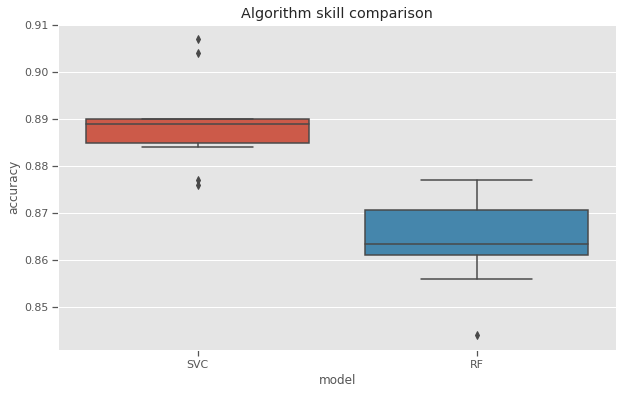

In [15]:
# Boxplots of skill
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
sn.boxplot(data=res_df, x="model", y=metric, ax=ax, order=avg_df.index)
_ = ax.set_title("Algorithm skill comparison")

**Note the log y-axis on the bar plot below - KNN is *very* slow to predict!**

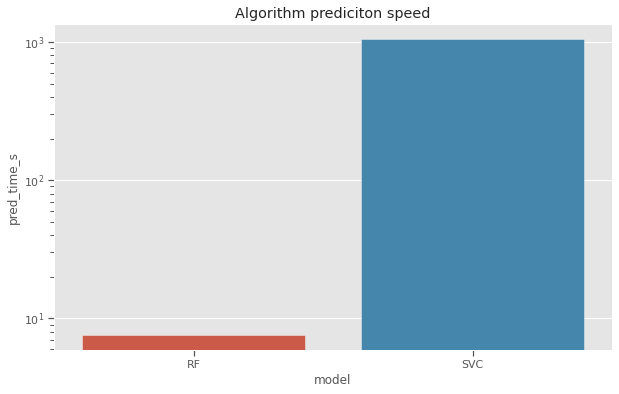

In [16]:
# Prediction speed
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
sn.barplot(
    data=avg_df,
    x=avg_df.index,
    y="pred_time_s",
    ax=ax,
    order=avg_df.sort_values("pred_time_s").index,
)
_ = ax.set_title("Algorithm prediciton speed")
ax.set_yscale('log')

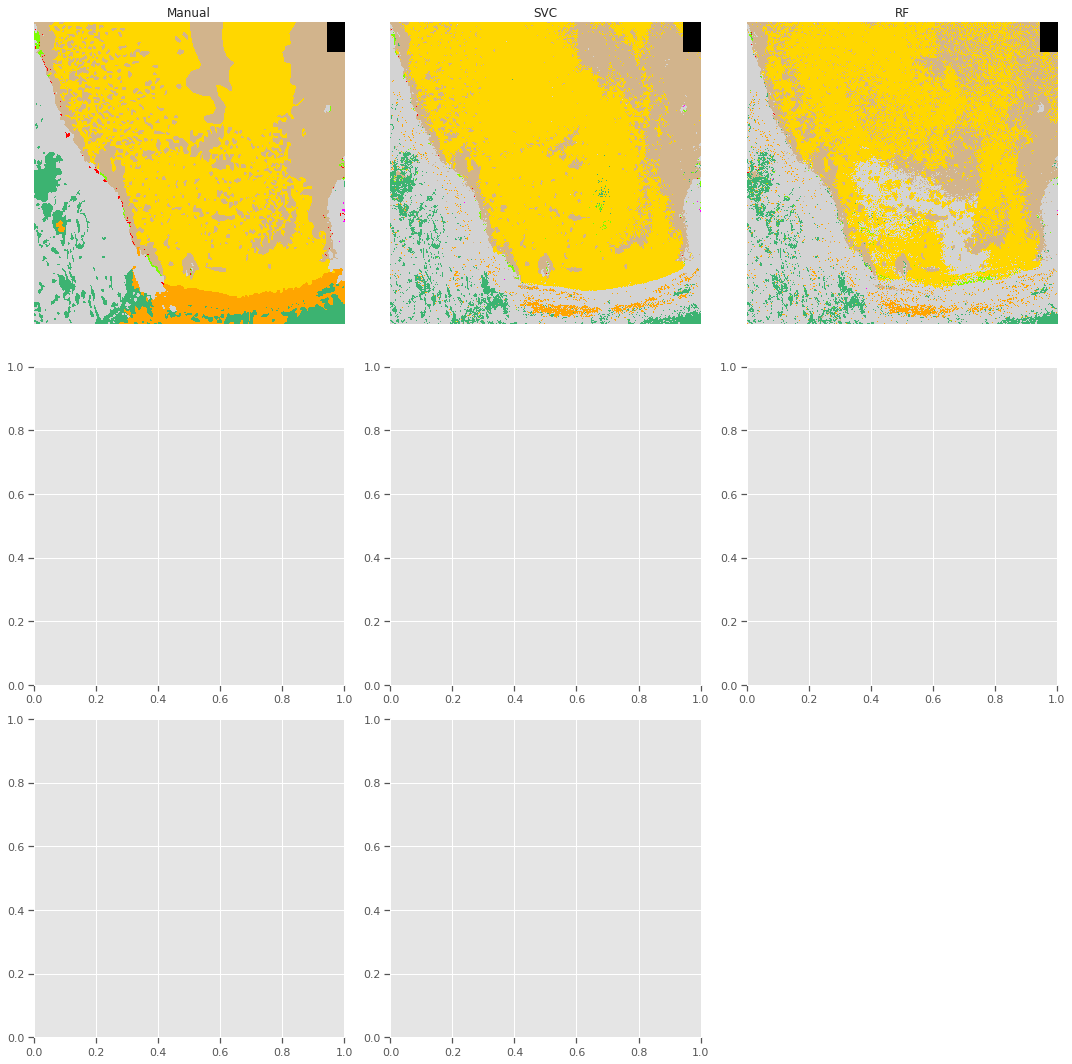

In [17]:
# Compare images predicted by each algorithm
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
axes = axes.flatten()
fig.delaxes(axes[-1])

for idx, name in enumerate(["Manual"] + list(avg_df.index)):
    img = axes[idx].imshow(
        pred_img_dict[name], cmap=cmap, norm=norm, interpolation="none"
    )
    axes[idx].set_title(name, fontsize=12)
    axes[idx].axis("off")
    
plt.tight_layout()

The output above compares the performance of the seven different models. It is also interesting to note **how long it takes to fit each model** (see the table above). This is important because we have a lot of data available in the full images (tens of millions of pixels) and we want to be able to use it effectively. If an algorithm is already slow here fitting just two million samples, it is unlikely to scale well to the larger dataset.

## 5. Time versus performance

We can view performance in two ways: model skill (e.g. accuracy) and computational speed. Different algorithms scale differently with the number of data samples, so it's worth exploring this further. The code below repeats the analysis above but for a range of different dataset sizes.

**This will take a long time to run (several hours)!**

In [18]:
# Number of CV folds
n_folds = 50

# Train sizes
train_sizes = [50e3, 200e3, 500e3, 1e6, 1.5e6, 2e6, 3e6]

# Container for results
df_list = []

# Prepare models
models = []
models.append(("LogReg", LogisticRegression(n_jobs=-1)))
models.append(("RidReg", RidgeClassifier()))
models.append(("LDA", LinearDiscriminantAnalysis()))
models.append(("KNN", KNeighborsClassifier(n_jobs=-1)))
models.append(("CART", DecisionTreeClassifier()))
models.append(("RF", RandomForestClassifier(max_depth=20, n_estimators=10, n_jobs=-1)))
models.append(("NB", GaussianNB()))

for train_size in train_sizes:
    print(f"Train size: {train_size}")
    # Split into training and evaluation
    cols = [str(i) for i in range(1, 9)]
    X_train, X_eval, y_train, y_eval = train_test_split(
        df[cols],
        df["y"],
        train_size=int(train_size),
        test_size=int(train_size),
        random_state=seed,
        shuffle=True,
    )

    # Evaluate each model in turn
    for name, model in models:
        print(f"    Fitting {model}")
        start = time.time()
        kfold = model_selection.KFold(
            n_splits=n_folds,
            random_state=seed,
            shuffle=True,
        )
        cv_results = model_selection.cross_val_score(
            model, X_train, y_train, cv=kfold, scoring=metric, n_jobs=-1
        )
        end = time.time()

        # Build results dataframe
        res_df = pd.DataFrame(
            {
                "model": name,
                "n_samples": len(X_train),
                "fold": range(1, n_folds + 1),
                metric: cv_results,
                "train_time_per_fold_s": (end - start) / n_folds,
            }
        )
        df_list.append(res_df)

print("Done.")

res_df = pd.concat(df_list, axis="rows")
res_df.to_csv(r"../results/model_comparison.csv", index=False)

Train size: 50000.0
    Fitting LogisticRegression(n_jobs=-1)


KeyboardInterrupt: 

In [ ]:
time_df = res_df.groupby(["model", "n_samples"]).mean().reset_index()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
sn.lineplot(
    data=time_df,
    x="n_samples",
    y="train_time_per_fold_s",
    hue="model",
    marker="o",
    markersize=10,
)

In [ ]:
# Get the average scores for the largest training dataset
max_n_samples = res_df["n_samples"].max()
avg_df = res_df.query("n_samples == @max_n_samples")
avg_df = (
    avg_df.groupby("model")
    .mean()[[metric, "train_time_per_fold_s"]]
    .sort_values(metric, ascending=False)
)
avg_df

In [ ]:
# Boxplots over all training dataset sizes
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
sn.boxplot(data=res_df, x="model", y=metric, ax=ax, order=avg_df.index)
_ = ax.set_title("Algorithm Comparison")

I haven't done much experimenting with this myself yet, but my inital impression is that the `RandomForestClassifier` and the `KNeighborsClassifier` consistently provide good accuracy and computational performance. As the dataset size grows, I would expect the performance of the random forest to scale better than the KNN algorithm, but it will be interesting to see what you find.

**Good luck! :-)**